# **Modeling and Evaluation**

## Objectives

* Fit and evaluate a model pipeline to predict chargers

## Inputs

* Engineered features 'output/datasets/engineered/insurance_engineered.csv' 

## Outputs

* Model pipeline


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/medical-insurance-prediction/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/medical-insurance-prediction'

---

# Load Engineered Dataset

In [4]:
import pandas as pd
df_path = 'outputs/datasets/engineered/insurance_engineered.csv'
df_processed = pd.read_csv(df_path)
df_processed.head()

,age,age_squared,sex_encoded,bmi,children,smoker_encoded,is_overweight,smoker_bmi_risk,age_bmi_risk,risk_score,region_northwest,region_southeast,region_southwest,age_group_Adult,age_group_Middle-aged,age_group_Senior,bmi_class_Normal,bmi_class_Overweight,bmi_class_Obese,charges
0,-1.438764,-1.220462,0,-0.453320,0,1,1,1.699463,-1.304476,65,False,False,True,False,False,False,False,True,False,16884.92400
1,-1.509965,-1.253341,1,0.509621,1,0,1,-0.494516,-1.155629,35,False,True,False,False,False,False,False,False,True,1725.55230
2,-0.797954,-0.844579,1,0.383307,3,0,1,-0.494516,-0.550476,45,False,True,False,True,False,False,False,False,True,4449.46200
3,-0.441948,-0.573551,1,-1.305531,0,0,0,-0.494516,-0.884952,0,True,False,False,True,False,False,True,False,False,21984.47061
4,-0.513149,-0.631311,1,-0.292556,0,0,1,-0.494516,-0.550170,15,True,False,False,True,False,False,False,True,False,3866.85520


---

Disable warnings

# Train/Test Split

Split features and target

In [5]:
# Features (X) and Target (y)
X = df_processed.drop('charges', axis=1)
y = df_processed['charges']

Train/Test split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

print(f"X_train shape: {X_train.shape}  y_train shape: {y_train.shape}"
      f"\nX_test shape: {X_test.shape}  y_test shape: {y_test.shape}")

X_train shape: (1070, 19)  y_train shape: (1070,)
X_test shape: (268, 19)  y_test shape: (268,)


---

# Define Hyperparameters and Models

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {
            "fit_intercept": [True, False],
            "normalize": [False]  # normalize deprecated in newer sklearn, keep False
        }
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {
            "alpha": [0.01, 0.1, 1, 10, 100],
            "fit_intercept": [True, False]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5],
        }
    },
    "XGBoost": {
        "model": XGBRegressor(objective='reg:squarederror', random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 6],
            "learning_rate": [0.01, 0.1],
            "subsample": [0.8, 1.0]
        }
    }
}


## Train and Evaluate All Models

In [13]:
best_model_name = None
best_model_obj = None
best_score = -np.inf 

results = []

for name, cfg in models.items():
    print(f"Training {name}...")
    if name == "Linear Regression" and "normalize" in cfg["params"]:
        del cfg["params"]["normalize"]
    
    grid = GridSearchCV(cfg["model"], cfg["params"], cv=5, scoring="r2", n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    if r2 > best_score:
        best_score = r2
        best_model_name = name
        best_model_obj = best_model

    results.append({
        "Model": name,
        "R²": round(r2, 3),
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2)
    })



Training Linear Regression...
Training Ridge Regression...
Training Random Forest...
Training XGBoost...


/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_

Show Results Table

In [14]:
import matplotlib.pyplot as plt

def plot_tree_model_features(model, feature_names, title):
    importances = model.feature_importances_
    sorted_idx = np.argsort(importances)[::-1]
    top_features = [feature_names[i] for i in sorted_idx]
    top_importances = importances[sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_importances)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Feature Importance")
    plt.grid(True)
    plt.show()

def plot_linear_model_coefficients(model, feature_names, title):
    coefs = model.coef_
    sorted_idx = np.argsort(np.abs(coefs))[::-1]
    top_features = [feature_names[i] for i in sorted_idx]
    top_coefs = coefs[sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_coefs)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Coefficient Value")
    plt.grid(True)
    plt.show()


In [16]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="R²", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)

print("Model Evaluation Results:")
print(results_df)

Model Evaluation Results:
               Model     R²     RMSE      MAE
0            XGBoost  0.870  4416.11  2321.66
1  Linear Regression  0.859  4604.20  2786.53
2   Ridge Regression  0.857  4631.56  2817.84
3      Random Forest  0.846  4802.28  2617.08



Best Model: XGBoost


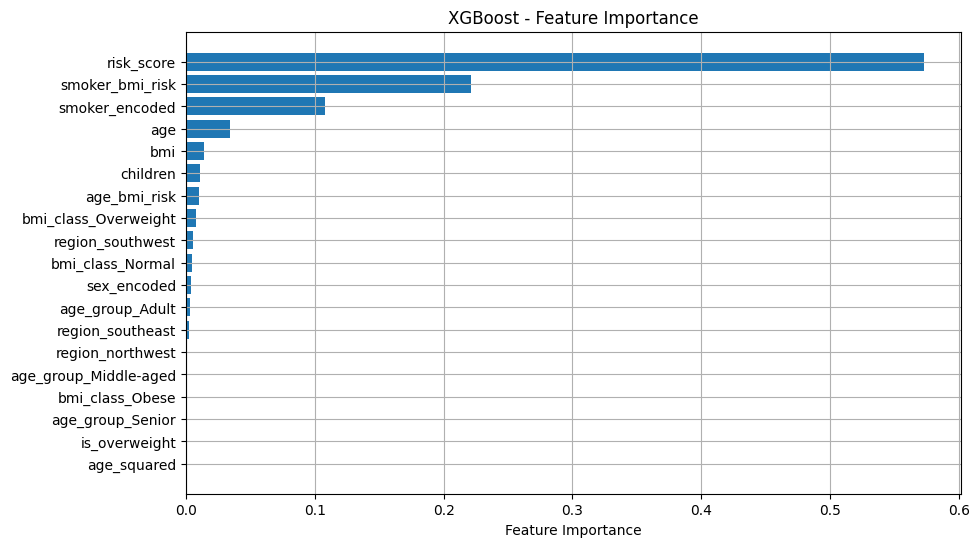

In [15]:
feature_names = X_train.columns.tolist()

print(f"\nBest Model: {best_model_name}")
if best_model_name in ["Random Forest", "XGBoost"]:
    plot_tree_model_features(best_model_obj, feature_names, f"{best_model_name} - Feature Importance")
elif best_model_name in ["Linear Regression", "Ridge Regression"]:
    plot_linear_model_coefficients(best_model_obj, feature_names, f"{best_model_name} - Coefficients")
else:
    print("Feature importance plot not available for this model.")


* GridSearchCV uses 5-fold cross-validation by default
* Models are sorted by R² (higher = better fit)
* The best models is XGBRegressor. The best hyperparameters are:
  * `max_depth=3`
  * `n_estimators=100`
  * `learning_rate=0.1`
  * `subsample=0.8`
  * `colsample_bytree=0.8`


# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
